Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH

In [0]:
%tensorflow_version 2.x

In [0]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

In [3]:
if 1:
    !pip install scikit-video==1.1.11
import skvideo.io

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [4]:
if 1:
    !wget http://www.nada.kth.se/cvap/actions/walking.zip
    !wget http://www.nada.kth.se/cvap/actions/jogging.zip
    !wget http://www.nada.kth.se/cvap/actions/running.zip
    !wget http://www.nada.kth.se/cvap/actions/boxing.zip
    !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
    !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if 1:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

--2020-05-15 18:32:38--  http://www.nada.kth.se/cvap/actions/walking.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::82ed:1c29
Connecting to www.nada.kth.se (www.nada.kth.se)|130.237.28.41|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.csc.kth.se/cvap/actions/walking.zip [following]
--2020-05-15 18:32:39--  https://www.csc.kth.se/cvap/actions/walking.zip
Resolving www.csc.kth.se (www.csc.kth.se)... 130.237.227.116
Connecting to www.csc.kth.se (www.csc.kth.se)|130.237.227.116|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘walking.zip’

walking.zip             [              <=>   ] 231.21M  3.59MB/s    in 68s     

2020-05-15 18:33:49 (3.39 MB/s) - ‘walking.zip’ saved [242442411]

--2020-05-15 18:33:50--  http://www.nada.kth.se/cvap/actions/jogging.zip
Resolving www.nada.kth.se (www.nada.kth.se)... 130.237.28.41, 2001:6b0:1:11c2::

In [5]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

dataset = []
data_root = './'
for cls in classes:
    print('Processing class: {}'.format(cls))
    for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
        cls_idx = classes.index(cls)
        dataset.append((fpath, cls_idx))

Processing class: walking
Processing class: jogging
Processing class: running
Processing class: boxing
Processing class: handwaving
Processing class: handclapping


In [0]:
SUBSET_LEN = 180
random.shuffle(dataset)
dataset = dataset[:SUBSET_LEN]

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv3D(32, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (5, 5, 5), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 2, 2), padding='same', activation='relu'),
    tf.keras.layers.MaxPool3D((1, 2, 2), padding='same'),
    tf.keras.layers.Conv3D(64, (3, 3, 3), (1, 1, 1), padding='same', activation=None),
    tf.keras.layers.GlobalAveragePooling3D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(6, activation=None),
])

In [0]:
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

In [10]:
global_step = 0
for ep in range(NUM_EPOCHS):
    for iter, (fpath, label) in enumerate(dataset):
        videodata = skvideo.io.vread(fpath)
        videodata = videodata.astype(np.float32) / 255.
        motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
        x = motion[None, ...]
        y = np.array(label)[None, ...]

        loss_value = model.train_on_batch(x, y)

        if iter % 10 == 0:
            print(f'[{ep}/{NUM_EPOCHS}][{iter}/{len(dataset)}] Loss = {loss_value}')

        global_step += 1

[0/10][0/180] Loss = 1.6594641208648682
[0/10][10/180] Loss = 1.7800029516220093
[0/10][20/180] Loss = 1.7968641519546509
[0/10][30/180] Loss = 1.801927924156189
[0/10][40/180] Loss = 1.7901052236557007
[0/10][50/180] Loss = 1.7898005247116089
[0/10][60/180] Loss = 1.8904953002929688
[0/10][70/180] Loss = 1.7270268201828003
[0/10][80/180] Loss = 1.9126524925231934
[0/10][90/180] Loss = 1.770079255104065
[0/10][100/180] Loss = 1.7624043226242065
[0/10][110/180] Loss = 1.7372055053710938
[0/10][120/180] Loss = 1.830116868019104
[0/10][130/180] Loss = 1.8115743398666382
[0/10][140/180] Loss = 1.803571105003357
[0/10][150/180] Loss = 2.0997438430786133
[0/10][160/180] Loss = 1.8704878091812134
[0/10][170/180] Loss = 1.8137873411178589
[1/10][0/180] Loss = 1.748355507850647
[1/10][10/180] Loss = 1.873213291168213
[1/10][20/180] Loss = 1.0761765241622925
[1/10][30/180] Loss = 1.6311736106872559
[1/10][40/180] Loss = 1.4889180660247803
[1/10][50/180] Loss = 1.2323273420333862
[1/10][60/180] L

In [0]:
def test_pred():
  fpath, cls_true = random.choice(dataset)

  videodata = skvideo.io.vread(fpath)
  videodata = videodata.astype(np.float32) / 255.
  plt.imshow(videodata[30, ...])

  motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

  out = model(motion[None, ...])[0]
  cls_pred = np.argmax(out.numpy())

  print('True class:', classes[cls_true])
  print('Predicted class:', classes[cls_pred])

True class: handwaving
Predicted class: handwaving


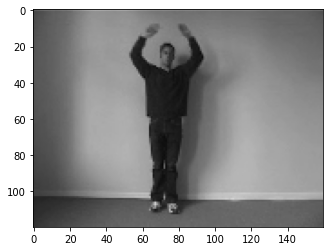

In [16]:
test_pred()

True class: jogging
Predicted class: walking


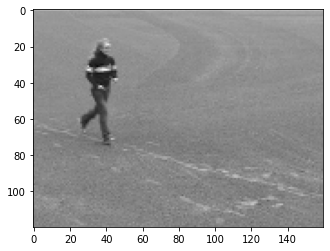

In [18]:
test_pred()

True class: boxing
Predicted class: boxing


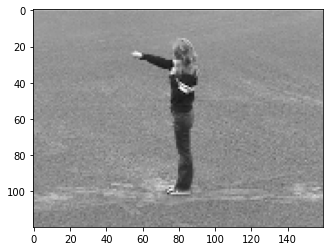

In [19]:
test_pred()

True class: handclapping
Predicted class: handclapping


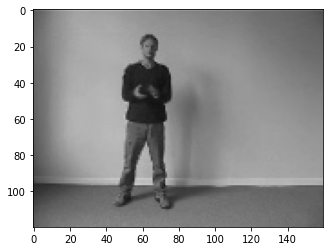

In [20]:
test_pred()

True class: boxing
Predicted class: boxing


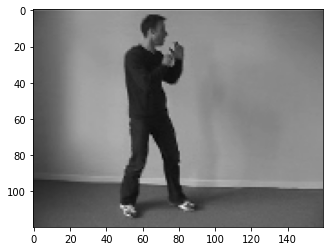

In [21]:
test_pred()

True class: jogging
Predicted class: walking


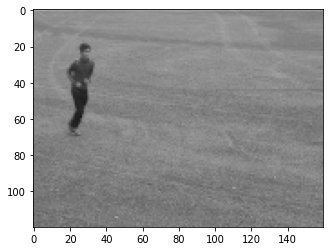

In [22]:
test_pred()